In [1]:
import numpy as np
import pandas as pd
from gtda.mapper import (
    CubicalCover,
    OneDimensionalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph
)
from gtda.mapper.cluster import ParallelClustering
from gtda.mapper import Eccentricity,Entropy

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN, KMeans,MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, OPTICS

In [2]:
import openpyxl
xlsx = pd.ExcelFile('41591_2020_897_MOESM3_ESM.xlsx')
df1 = pd.read_excel(xlsx, '(B) Figure 1B')
df3 = pd.read_excel(xlsx, '(P) ED Fig.6')

In [3]:
df3[['Days after symptoms onset']] =np.abs(df3[['Days after symptoms onset']])

In [4]:
x = df3['Patient ID']

In [5]:
r = []
for i in x:
    r.append(df1.iloc[df1.index[df1['Patient ID'] == i]].Severity.iloc[0])

In [6]:
df3['Severity'] = r

In [7]:
sum(df3['Severity'])

34

In [8]:
len(set(df3['Patient ID']))

41

In [9]:
max(df3['Days after symptoms onset'])

33

In [10]:
df3 = df3.rename({'Patient ID': 'ID', 'Days after symptoms onset': 'Días despues de iniciados los síntomas', 'IgG (S/CO)': 'IgG S/CO', 'IgM (S/CO)': 'IgM S/CO', 'Severity': 'Severidad'}, axis=1)

In [11]:
df3

,ID,Días despues de iniciados los síntomas,IgG S/CO,IgM S/CO,Severidad
0,1,4,36.272,0.162,0
1,1,7,196.891,0.642,0
2,1,10,252.084,0.928,0
3,1,13,246.375,1.033,0
4,2,4,4.072,0.738,1
...,...,...,...,...,...
188,64,4,2.692,1.637,0
189,64,2,11.192,2.857,0
190,64,5,39.314,4.913,0
191,64,8,34.074,5.240,0


### Number of patients

In [12]:
count = df3.drop_duplicates(subset = ['ID'], keep = 'first', inplace = False) 
len(count)

41

### Number of several patients

In [13]:
sum(count['Severidad'])

7

### Making the table with the weeks.

In [14]:
df3_week =pd.DataFrame.copy(df3)

In [15]:
aux= []
for i in range(len(df3)):
    if 0<= df3['Días despues de iniciados los síntomas'][i]<8:
        aux.append('1ra semana')
    elif 8<= df3['Días despues de iniciados los síntomas'][i]<15:
        aux.append('2nda semana')
    elif 15<= df3['Días despues de iniciados los síntomas'][i]<22:
        aux.append('3ra semana')
    elif 22<= df3['Días despues de iniciados los síntomas'][i]<29:
        aux.append('4ta semana')
    else:
        aux.append('5ta semana')

In [16]:
df3_week['Semana'] = aux

In [17]:
df3_week

,ID,Días despues de iniciados los síntomas,IgG S/CO,IgM S/CO,Severidad,Semana
0,1,4,36.272,0.162,0,1ra semana
1,1,7,196.891,0.642,0,1ra semana
2,1,10,252.084,0.928,0,2nda semana
3,1,13,246.375,1.033,0,2nda semana
4,2,4,4.072,0.738,1,1ra semana
...,...,...,...,...,...,...
188,64,4,2.692,1.637,0,1ra semana
189,64,2,11.192,2.857,0,1ra semana
190,64,5,39.314,4.913,0,1ra semana
191,64,8,34.074,5.240,0,2nda semana


In [18]:
sum(df3_week['Severidad'])

34

# 1. 1 With patient ID, without Severity

## Filter: Eccentricity

In [19]:
filter_func = Eccentricity(exponent = 2,metric= 'cosine')
cover = OneDimensionalCover(n_intervals=100, overlap_frac=0.88, kind = 'balanced')

clusterer = DBSCAN(eps = 0.1,metric='cosine')
#clusterer = AgglomerativeClustering(n_clusters=3,linkage='single')


n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    contract_nodes=True,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)

In [20]:
node_scale = 20
fig = plot_interactive_mapper_graph(pipe, 
                                    df3.drop(['Severidad'],axis=1), 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    node_color_statistic=np.mean,
                                    color_data=df3
                                   ),
fig[0]

In [21]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Constructing the table for green group.

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from seaborn import histplot as hist
sns.set_theme(style="whitegrid")
%matplotlib inline

In [23]:
graph = pipe.fit_transform(df3.drop(['Severidad'],axis=1))
node_elements = graph.vs["node_elements"]

In [24]:
range(len(node_elements))

range(0, 114)

### Groups of nodes:
- Group $D$: Nodes with $100\%$ of samples from severe patients.
- Group $E$: Nodes with $40\%-90\%$.
- Group $F\cup G$: Nodes with $0\%$.
- Group $F$: Nodes with at least $12$ samples of $F\cup G$.
- Group $G$: Rest of the nodes of $F\cup G$.

In [25]:
group1 = [0,1,6,7,8]
group2 = [13,14,15,16,17,53,85]

### Recovering the samples of each node.

In [26]:
graph = pipe.fit_transform(df3.drop(['Severidad'],axis=1))
def Nodes(nodes, data,pipe):
    graph = pipe.fit_transform(data)
    node_id = []
    node_elements = graph.vs["node_elements"]
    ne = []
    da = []
    data_points = []
    for i in nodes:
        node_id.append(i)
        ne.append(node_elements[node_id[-1]])
        x = np.asarray(df3_week.iloc[node_elements[node_id[-1]]])
        data_points.append(x)    
    return node_id,ne,data_points

In [27]:
a1,b1,c1 = Nodes(group1, df3.drop(['Severidad'],axis=1), pipe)
a2,b2,c2 = Nodes(group2, df3.drop(['Severidad'],axis=1), pipe)

In [28]:
len(c1),len(c2)

(5, 7)

In [29]:
def table(x):
    IgGg = []
    IgMg = []
    #GMg = []
    #Daysg = []
    #Severig = []

    for i in range(len(x)):
        IgGg.append(np.array([[x[i][k][0], x[i][k][1], x[i][k][2], x[i][k][4], x[i][k][-1]] for k in range(len(x[i]))]))
        IgMg.append(np.array([[x[i][k][0], x[i][k][1], x[i][k][3], x[i][k][4], x[i][k][-1]] for k in range(len(x[i]))]))

    IgGg = np.unique(np.concatenate(IgGg),axis = 0)
    IgMg = np.unique(np.concatenate(IgMg),axis = 0)
    IgGg = pd.DataFrame(IgGg, columns = ['ID', 'Días', 'Niveles de anticuerpos', 'Severidad','Semana'])
    IgMg = pd.DataFrame(IgMg, columns = ['ID', 'Días', 'Niveles de anticuerpos', 'Severidad','Semana'])
    
    #sever_IgG = IgGg[IgGg['Severity'] == '1']
    #not_sever_IgG = IgGg[IgGg['Severity'] == '0']
    #sever_IgM = IgMg[IgMg['Severity'] == '1']
    #not_sever_IgM = IgMg[IgMg['Severity'] == '0']
    
    #IgG_group_x = pd.concat([sever_IgG, not_sever_IgG])
    IgG_group_x = IgGg
    
    #IgM_group_x = pd.concat([sever_IgM, not_sever_IgM])
    IgM_group_x = IgMg
    
    for i in range(len(IgG_group_x)):
        if IgG_group_x['Severidad'][i] == '1':
            IgG_group_x['Severidad'][i] = 'Severo'
        elif IgG_group_x['Severidad'][i] == '0':
            IgG_group_x['Severidad'][i] = 'No severo'
        
    for i in range(len(IgM_group_x)):
        if IgM_group_x['Severidad'][i] == '1':
            IgM_group_x['Severidad'][i] = 'Severo'
        elif IgM_group_x['Severidad'][i] == '0':
            IgM_group_x['Severidad'][i] = 'No severo'
            
    IgG_group_x = IgG_group_x.astype({"ID": int, "Días": int, "Niveles de anticuerpos": float, "Severidad": str, "Semana": str})
    IgM_group_x = IgM_group_x.astype({"ID": int, "Días": int, "Niveles de anticuerpos": float, "Severidad": str, "Semana": str})

    IgG_group_x['Niveles de anticuerpos'] = np.log2(IgG_group_x['Niveles de anticuerpos'])
    IgM_group_x['Niveles de anticuerpos'] = np.log2(IgM_group_x['Niveles de anticuerpos'])
    
    IgG_group_x = IgG_group_x.sort_values(by=['ID', 'Días'])
    IgM_group_x = IgM_group_x.sort_values(by=['ID', 'Días'])
    
    print('Max. día:', max(IgG_group_x['Días']))
    return IgG_group_x, IgM_group_x

### Tables of each group

In [30]:
IgG_group1, IgM_group1= table(c1)

Max. día: 25


In [31]:
IgG_group2, IgM_group2= table(c2)

Max. día: 30


In [32]:
len(IgG_group1), len(IgG_group2)

(17, 19)

In [39]:
def times(dataG, dataM, st,a,b):
    ID_unique = dataG.sort_values(by = ['ID'])['ID'].unique()
    np.random.seed(5)
    mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(ID_unique), replace=False)


    fig, ax = plt.subplots(1,2, figsize=(13,4), sharey = True)
    for i, y  in enumerate(ID_unique):        
            #if i > 0:
                ax[0].plot('Días', 'Niveles de anticuerpos', 
                           data=dataG.loc[dataG.ID==y, :], 
                           color=mycolors[i], 
                           label=y,
                           linewidth=2,
                           marker=".", 
                           markersize=8)

    for i, y  in enumerate(ID_unique):        
            #if i > 0:
                ax[1].plot('Días', 'Niveles de anticuerpos', 
                           data=dataM.loc[dataM.ID==y, :], 
                           color=mycolors[i], 
                           label=y,
                           linewidth=2,
                           marker=".", 
                           markersize=8)



    ax[0].set_title('IgG', fontsize=15)
    ax[1].set_title('IgM', fontsize=15)

    ax[0].set_xlabel('Días')
    ax[1].set_xlabel('Días')

    ax[0].set_ylabel('$\log_2$(Niveles de anticuerpos)')

    ax[0].set_xlim(a, b)
    ax[1].set_xlim(a, b)

    ax[0].set_ylim(-3.5, 10)
    ax[1].set_ylim(-3.5, 10)

    lines, labels = ax[0].get_legend_handles_labels()
    lines2, labels2 = ax[1].get_legend_handles_labels()

    ax[0].legend(lines, labels,bbox_to_anchor=(2.6, 0.5),loc = 'center right' ,ncol=2,title="ID")
    #ax[1].legend(lines2, labels2, loc='upper right')

    plt.suptitle('Grupo {0}'.format(st).replace("f", ""), fontsize=20)
    plt.savefig('{0}.pdf'.format(st),bbox_inches='tight')
    plt.show()

### Grupo 1

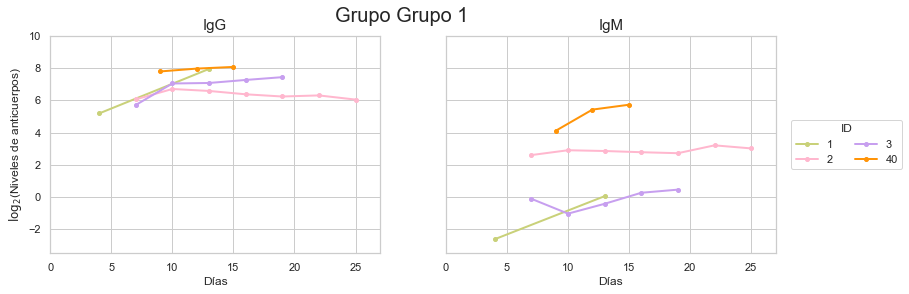

In [49]:
times(IgG_group1, IgM_group1, 'Grupo 1', 0, 27)

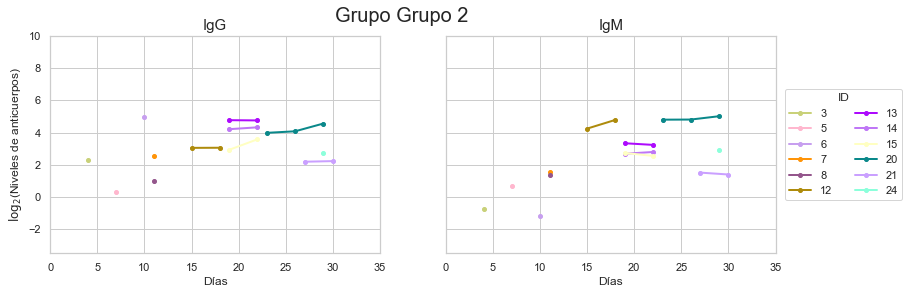

In [52]:
times(IgG_group2, IgM_group2, 'Grupo 2', 0, 35)

In [131]:
def histo_sev(dataG, dataM, x):
    if x != 'C':
        fig, ax = plt.subplots(1,2, figsize=(16,5), sharey = True)  

        sns.boxplot(x = 'Severidad',
                             y = 'Niveles de anticuerpos',
                             order = ['Severo', 'No severo'],
                             data = dataG,
                             palette="Set3",
                             ax=ax[0]
                            )

        sns.stripplot(x = 'Severidad',
                          y = 'Niveles de anticuerpos',
                          order = ['Severo', 'No severo'],
                          data = dataG,
                          palette="Set1",
                          ax=ax[0]
                          )

        sns.boxplot(x = 'Severidad',
                             y = 'Niveles de anticuerpos',
                             order = ['Severo', 'No severo'],
                             data = dataM,
                             palette="Set3",
                             ax=ax[1]
                            )

        sns.stripplot(x = 'Severidad',
                          y = 'Niveles de anticuerpos',
                          order = ['Severo', 'No severo'],
                          data = dataM,
                          palette="Set1",
                          ax=ax[1]
                          )


        ax[0].set(xlabel=None,ylim=(-5, 9))
        ax[1].set(xlabel=None)
        ax[0].set(ylabel='$\log_2$(Niveles de anticuerpos)')
        ax[1].set(ylabel=None)
        ax[0].set_title('IgG', fontsize=15)
        ax[1].set_title('IgM', fontsize=15)
        fig.suptitle("Grupo {0}".format(x), fontsize=20)
        plt.savefig('{0}.pdf'.format(x))
    else:
        fig, ax = plt.subplots(1,2, figsize=(16,5), sharey = True)  

        sns.boxplot(x = 'Severidad',
                             y = 'Niveles de anticuerpos',
                             #order = ['Severe', 'Non-severe'],
                             data = dataG,
                             palette="Set3",
                             ax=ax[0]
                            )

        sns.stripplot(x = 'Severidad',
                          y = 'Niveles de anticuerpos',
                          #order = ['Severe', 'Non-severe'],
                          data = dataG,
                          palette="Set1",
                          ax=ax[0]
                          )

        sns.boxplot(x = 'Severidad',
                             y = 'Niveles de anticuerpos',
                             #order = ['Severe', 'Non-severe'],
                             data = dataM,
                             palette="Set3",
                             ax=ax[1]
                            )

        sns.stripplot(x = 'Severidad',
                          y = 'Niveles de anticuerpos',
                          #order = ['Severe', 'Non-severe'],
                          data = dataM,
                          palette="Set1",
                          ax=ax[1]
                          )


        ax[0].set(xlabel=None,ylim=(-5, 9))
        ax[1].set(xlabel=None)
        ax[0].set(ylabel='$\log_2$(Niveles de anticuerpos)')
        ax[1].set(ylabel=None)
        ax[0].set_title('IgG', fontsize=15)
        ax[1].set_title('IgM', fontsize=15)
        fig.suptitle("Grupo {0}".replace("f", "").format(x), fontsize=20)
        plt.savefig('{0}.pdf'.format(x))

In [132]:
first_weeks_IgG_D = pd.concat([IgG_group_D[IgG_group_D['Semana'] =='1ra semana'], IgG_group_D[IgG_group_D['Semana'] =='2nda semana']])
first_weeks_IgG_E = pd.concat([IgG_group_E[IgG_group_E['Semana'] =='1ra semana'], IgG_group_E[IgG_group_E['Semana'] =='2nda semana']])
first_weeks_IgG_F = pd.concat([IgG_group_F[IgG_group_F['Semana'] =='1ra semana'], IgG_group_F[IgG_group_F['Semana'] =='2nda semana']])
first_weeks_IgG_G = pd.concat([IgG_group_G[IgG_group_G['Semana'] =='1ra semana'], IgG_group_G[IgG_group_G['Semana'] =='2nda semana']])

#first_weeks_IgG_AuB = pd.concat([IgG_group_AuB[IgG_group_AuB['Week'] =='1st week'], IgG_group_AuB[IgG_group_AuB['Week'] =='2nd week']])


first_weeks_IgM_D = pd.concat([IgM_group_D[IgM_group_D['Semana'] =='1ra semana'], IgM_group_D[IgM_group_D['Semana'] =='2nda semana']])
first_weeks_IgM_E = pd.concat([IgM_group_E[IgM_group_E['Semana'] =='1ra semana'], IgM_group_E[IgM_group_E['Semana'] =='2nda semana']])
first_weeks_IgM_F = pd.concat([IgM_group_F[IgM_group_F['Semana'] =='1ra semana'], IgM_group_F[IgM_group_F['Semana'] =='2nda semana']])
first_weeks_IgM_G = pd.concat([IgM_group_G[IgM_group_G['Semana'] =='1ra semana'], IgM_group_G[IgM_group_G['Semana'] =='2nda semana']])

#first_weeks_IgM_AuB = pd.concat([IgM_group_AuB[IgM_group_AuB['Week'] =='1st week'], IgM_group_AuB[IgM_group_AuB['Week'] =='2nd week']])


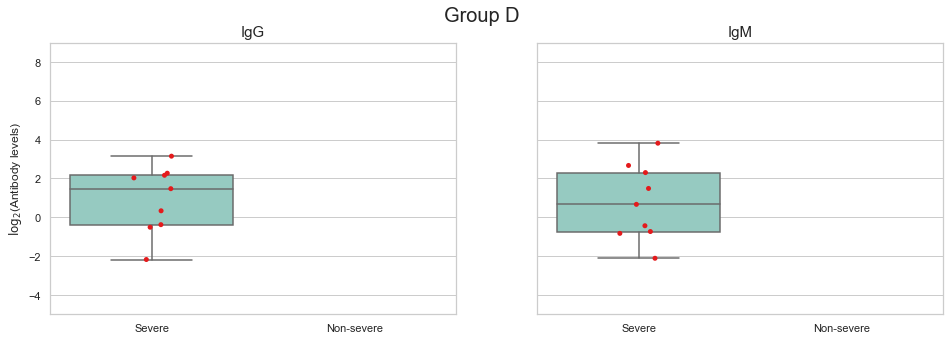

In [46]:
histo_sev(first_weeks_IgG_D,first_weeks_IgM_D, 'D')

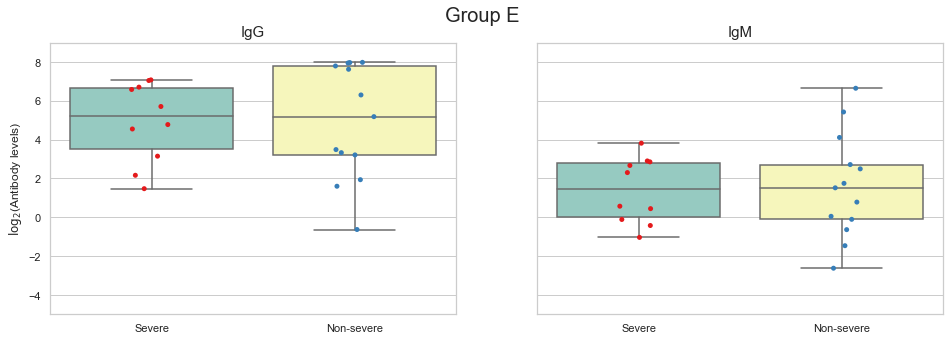

In [47]:
histo_sev(first_weeks_IgG_E,first_weeks_IgM_E, 'E')

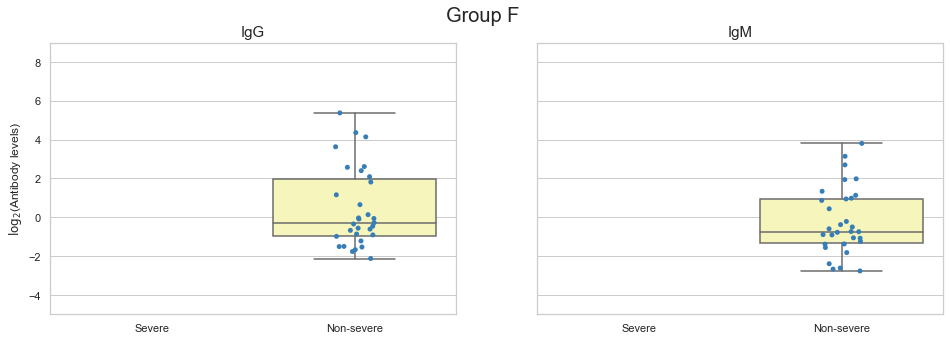

In [48]:
histo_sev(first_weeks_IgG_F,first_weeks_IgM_F, 'F')

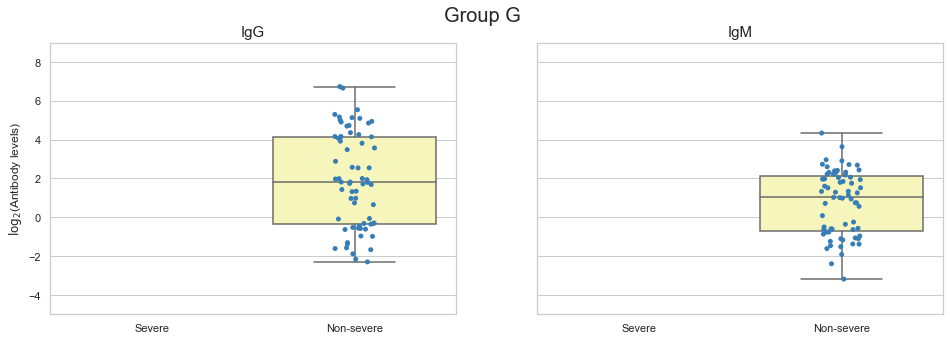

In [49]:
histo_sev(first_weeks_IgG_G,first_weeks_IgM_G, 'G')

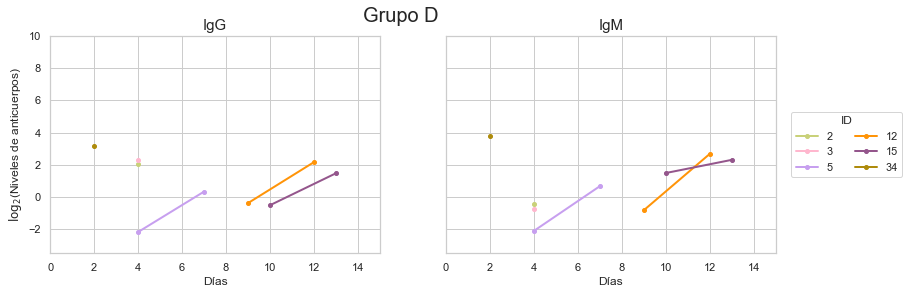

In [366]:
times(first_weeks_IgG_D, first_weeks_IgM_D, 'Df', 0, 15)

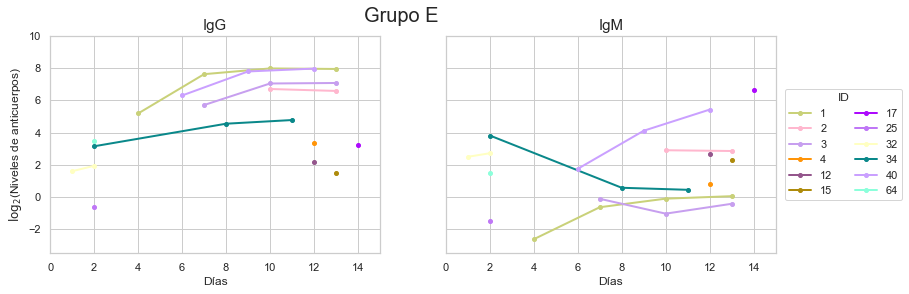

In [367]:
times(first_weeks_IgG_E, first_weeks_IgM_E, 'Ef', 0, 15)

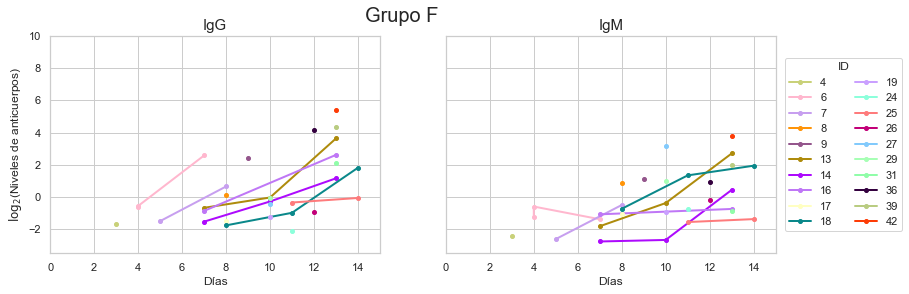

In [368]:
times(first_weeks_IgG_F, first_weeks_IgM_F, 'Ff', 0, 15)

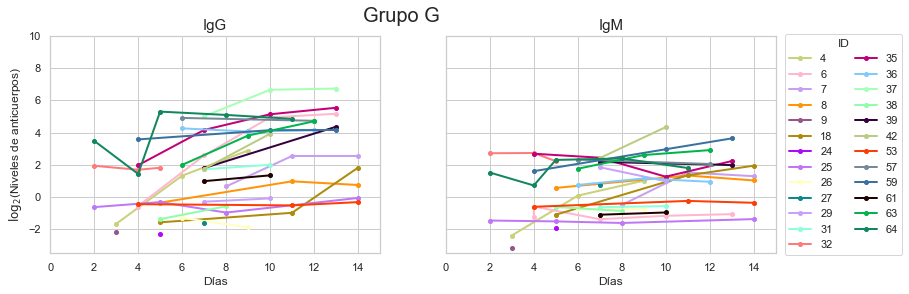

In [369]:
times(first_weeks_IgG_G, first_weeks_IgM_G, 'Gf', 0, 15)

In [370]:
df3_week

,ID,Días despues de iniciados los síntomas,IgG S/CO,IgM S/CO,Severidad,Semana
0,1,4,36.272,0.162,0,1ra semana
1,1,7,196.891,0.642,0,1ra semana
2,1,10,252.084,0.928,0,2nda semana
3,1,13,246.375,1.033,0,2nda semana
4,2,4,4.072,0.738,1,1ra semana
...,...,...,...,...,...,...
188,64,4,2.692,1.637,0,1ra semana
189,64,2,11.192,2.857,0,1ra semana
190,64,5,39.314,4.913,0,1ra semana
191,64,8,34.074,5.240,0,2nda semana


In [371]:
first_weeks_IgG_E[first_weeks_IgG_E['Severidad'] == 'Severo']

,ID,Días,Niveles de anticuerpos,Severidad,Semana
33,3,7,5.704180,Severo,1ra semana
37,34,2,3.145351,Severo,1ra semana
17,2,10,6.701133,Severo,2nda semana
18,2,13,6.580176,Severo,2nda semana
29,3,10,7.042393,Severo,2nda semana
30,3,13,7.074505,Severo,2nda semana
4,12,12,2.160920,Severo,2nda semana
8,15,13,1.470407,Severo,2nda semana
38,34,8,4.545660,Severo,2nda semana
36,34,11,4.773205,Severo,2nda semana


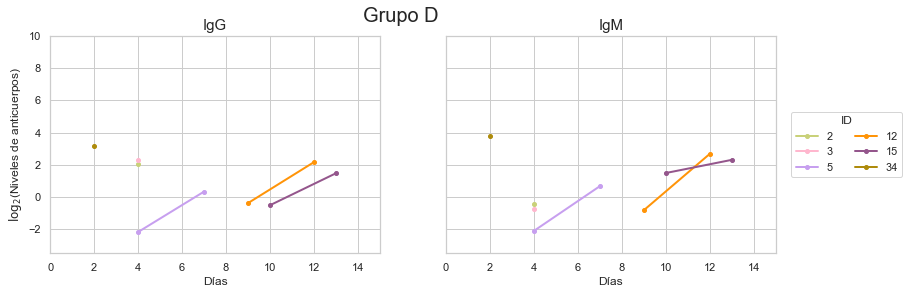

In [372]:
times(first_weeks_IgG_D[first_weeks_IgG_D['Severidad'] == 'Severo'], first_weeks_IgM_D[first_weeks_IgG_D['Severidad'] == 'Severo'], 'Dff', 0, 15)

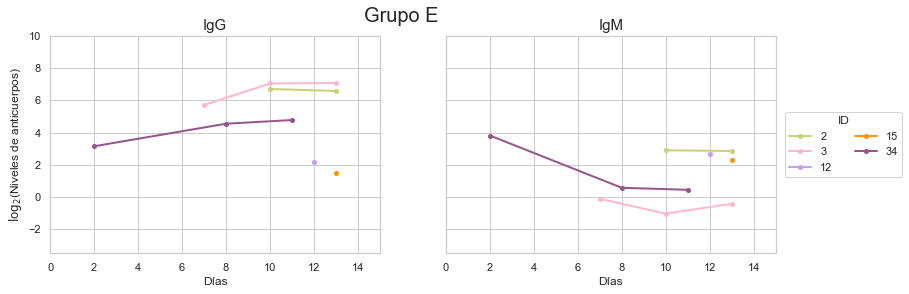

In [373]:
times(first_weeks_IgG_E[first_weeks_IgG_E['Severidad'] == 'Severo'], first_weeks_IgM_E[first_weeks_IgG_E['Severidad'] == 'Severo'], 'Eff', 0, 15)

In [438]:
s1 = first_weeks_IgG_D.sort_values(by = ['ID']).sort_values(by = ['Días'])
s2 = first_weeks_IgG_E.sort_values(by = ['ID']).sort_values(by = ['Días'])

In [439]:
s1 = s1[s1['ID']==5].append(s1[s1['ID']==12]).append(s1[s1['ID']==15])
s2 = s2[s2['ID']==2].append(s2[s2['ID']==3]).append(s2[s2['ID']==34])

In [440]:
s1

,ID,Días,Niveles de anticuerpos,Severidad,Semana
9,5,4,-2.177882,Severo,1ra semana
10,5,7,0.331132,Severo,1ra semana
2,12,9,-0.382702,Severo,2nda semana
0,12,12,2.160920,Severo,2nda semana
3,15,10,-0.514573,Severo,2nda semana
4,15,13,1.470407,Severo,2nda semana


In [441]:
s2

,ID,Días,Niveles de anticuerpos,Severidad,Semana
17,2,10,6.701133,Severo,2nda semana
18,2,13,6.580176,Severo,2nda semana
33,3,7,5.704180,Severo,1ra semana
29,3,10,7.042393,Severo,2nda semana
30,3,13,7.074505,Severo,2nda semana
37,34,2,3.145351,Severo,1ra semana
38,34,8,4.545660,Severo,2nda semana
36,34,11,4.773205,Severo,2nda semana


In [449]:
total1 = df3.sort_values(by = ['ID']).sort_values(by = ['Días despues de iniciados los síntomas'])
total2 = df3.sort_values(by = ['ID']).sort_values(by = ['Días despues de iniciados los síntomas'])

total1 = total1.rename({'Días despues de iniciados los síntomas': 'Días'}, axis=1)
total2 = total2.rename({'Días despues de iniciados los síntomas': 'Días'}, axis=1)

In [450]:
total1 = total1[total1['ID']==5].append(total1[total1['ID']==12]).append(total1[total1['ID']==15])
total2 = total2[total2['ID']==2].append(total2[total2['ID']==3]).append(total2[total2['ID']==34])

In [452]:
total1['IgG S/CO'] = np.log2(total1['IgG S/CO'])
total1['IgM S/CO'] = np.log2(total1['IgM S/CO'])

total2['IgG S/CO'] = np.log2(total2['IgG S/CO'])
total2['IgM S/CO'] = np.log2(total2['IgM S/CO'])

In [454]:
total1_IgG = total1.rename({'IgG S/CO': 'Niveles de anticuerpos'}, axis=1)
total1_IgM = total1.rename({'IgM S/CO': 'Niveles de anticuerpos'}, axis=1)

total2_IgG = total2.rename({'IgG S/CO': 'Niveles de anticuerpos'}, axis=1)
total2_IgM = total2.rename({'IgM S/CO': 'Niveles de anticuerpos'}, axis=1)

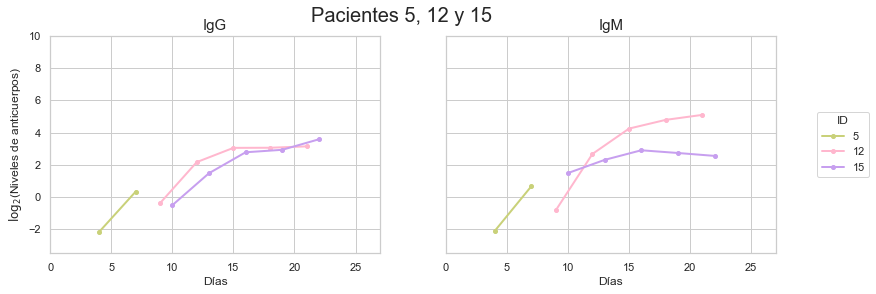

In [470]:
ID_unique = total1_IgG.sort_values(by = ['ID'])['ID'].unique()
np.random.seed(5)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(ID_unique), replace=False)


fig, ax = plt.subplots(1,2, figsize=(13,4), sharey = True)
for i, y  in enumerate(ID_unique):        
            #if i > 0:
                ax[0].plot('Días', 'Niveles de anticuerpos', 
                           data=total1_IgG.loc[total1_IgG.ID==y, :], 
                           color=mycolors[i], 
                           label=y,
                           linewidth=2,
                           marker=".", 
                           markersize=8)

for i, y  in enumerate(ID_unique):        
            #if i > 0:
                ax[1].plot('Días', 'Niveles de anticuerpos', 
                           data=total1_IgM.loc[total1_IgM.ID==y, :], 
                           color=mycolors[i], 
                           label=y,
                           linewidth=2,
                           marker=".", 
                           markersize=8)



ax[0].set_title('IgG', fontsize=15)
ax[1].set_title('IgM', fontsize=15)

ax[0].set_xlabel('Días')
ax[1].set_xlabel('Días')

ax[0].set_ylabel('$\log_2$(Niveles de anticuerpos)')

ax[0].set_xlim(0, 27)
ax[1].set_xlim(0, 27)

ax[0].set_ylim(-3.5, 10)
ax[1].set_ylim(-3.5, 10)

lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax[1].get_legend_handles_labels()

ax[0].legend(lines, labels,bbox_to_anchor=(2.5, 0.5),loc = 'center right' ,title="ID")
   
plt.suptitle('Pacientes 5, 12 y 15', fontsize=20)
plt.savefig('512.pdf', bbox_inches='tight')
plt.show()

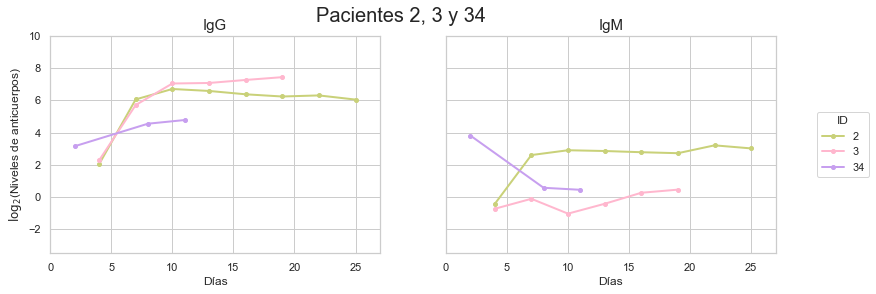

In [471]:
ID_unique = total2_IgG.sort_values(by = ['ID'])['ID'].unique()
np.random.seed(5)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(ID_unique), replace=False)


fig, ax = plt.subplots(1,2, figsize=(13,4), sharey = True)
for i, y  in enumerate(ID_unique):        
            #if i > 0:
                ax[0].plot('Días', 'Niveles de anticuerpos', 
                           data=total2_IgG.loc[total2_IgG.ID==y, :], 
                           color=mycolors[i], 
                           label=y,
                           linewidth=2,
                           marker=".", 
                           markersize=8)

for i, y  in enumerate(ID_unique):        
            #if i > 0:
                ax[1].plot('Días', 'Niveles de anticuerpos', 
                           data=total2_IgM.loc[total2_IgM.ID==y, :], 
                           color=mycolors[i], 
                           label=y,
                           linewidth=2,
                           marker=".", 
                           markersize=8)



ax[0].set_title('IgG', fontsize=15)
ax[1].set_title('IgM', fontsize=15)

ax[0].set_xlabel('Días')
ax[1].set_xlabel('Días')

ax[0].set_ylabel('$\log_2$(Niveles de anticuerpos)')

ax[0].set_xlim(0, 27)
ax[1].set_xlim(0, 27)

ax[0].set_ylim(-3.5, 10)
ax[1].set_ylim(-3.5, 10)

lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax[1].get_legend_handles_labels()

ax[0].legend(lines, labels,bbox_to_anchor=(2.5, 0.5),loc = 'center right',title="ID")
   
plt.suptitle('Pacientes 2, 3 y 34', fontsize=20)
plt.savefig('234.pdf', bbox_inches='tight')
plt.show()

## Tabla de parámetros

In [39]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [40]:
df3_export = pd.DataFrame.copy(df3)

In [41]:
df3_export = df3_export.astype({"ID": str, "Días despues de iniciados los síntomas": str, "IgG S/CO": float, "IgM S/CO": float, "Severidad": str})

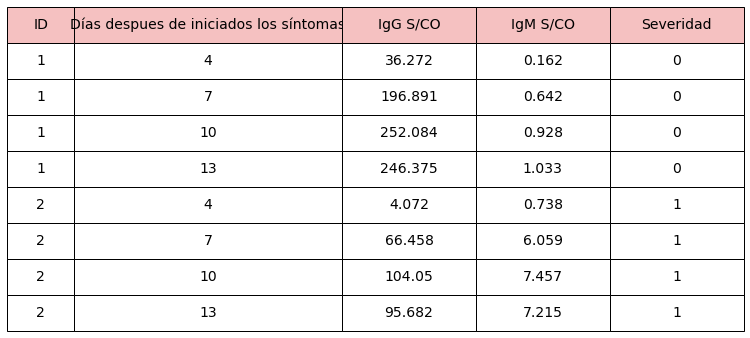

In [42]:
table2 = plt.table(cellText=df3_export.head(8).values, colLabels=df3_export.head(10).columns,
         cellLoc = 'center',
         loc = 'center',
         colLoc = 'center',
         rowLoc = 'center',
         colColours = ['#F5C1C1']*5,
         edges = 'closed',
         colWidths = [0.05,0.20,0.10,0.10,0.10]
         )
plt.axis('off')
table2.auto_set_font_size(False)
table2.set_fontsize(14)
table2.scale(4, 3)
fig = table2.figure

pp = PdfPages("table2.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()